In [1]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50

keras.backend.set_learning_phase(0)
keras_model = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(keras_model, bounds=(0, 255), preprocessing=preprocessing)
attack = foolbox.attacks.FGSM(fmodel)

Using TensorFlow backend.
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


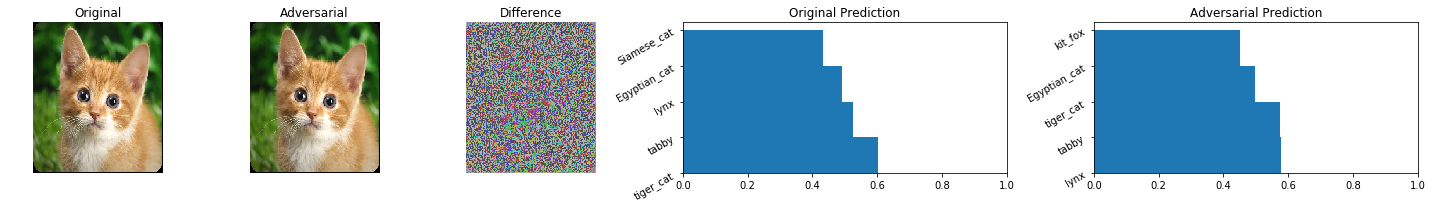

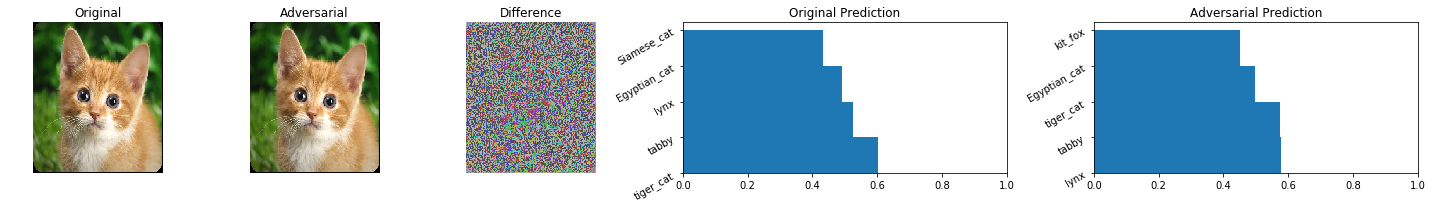

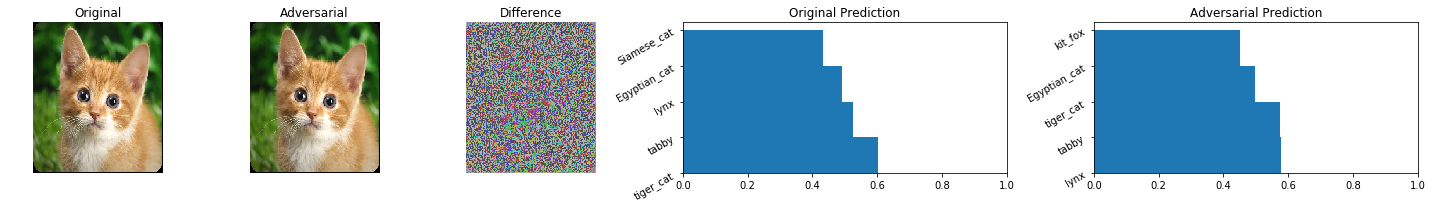

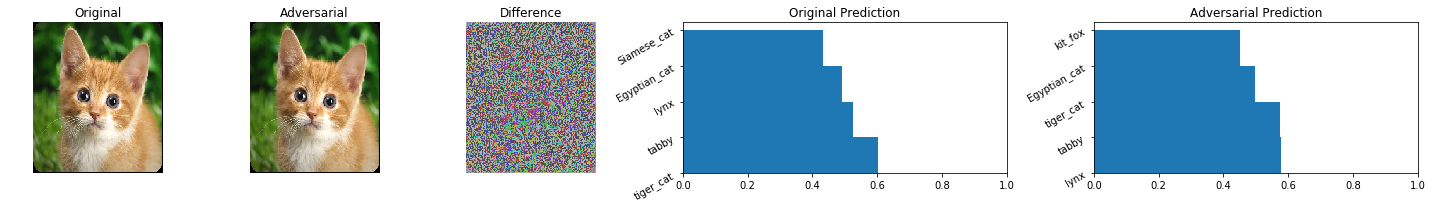

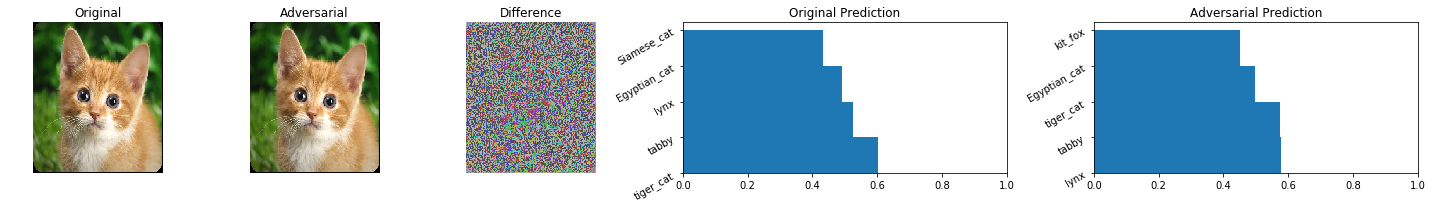

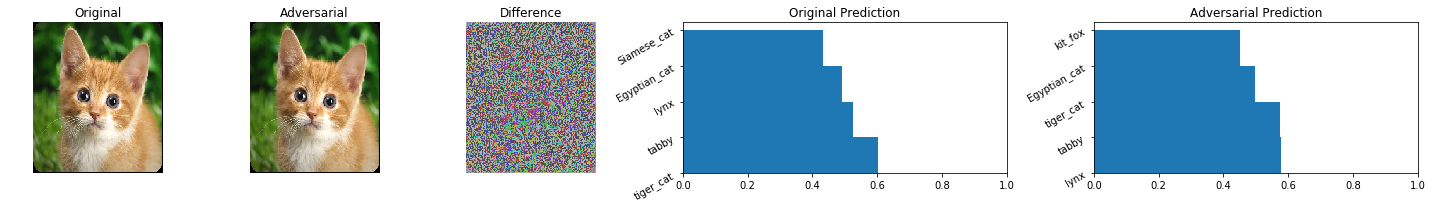

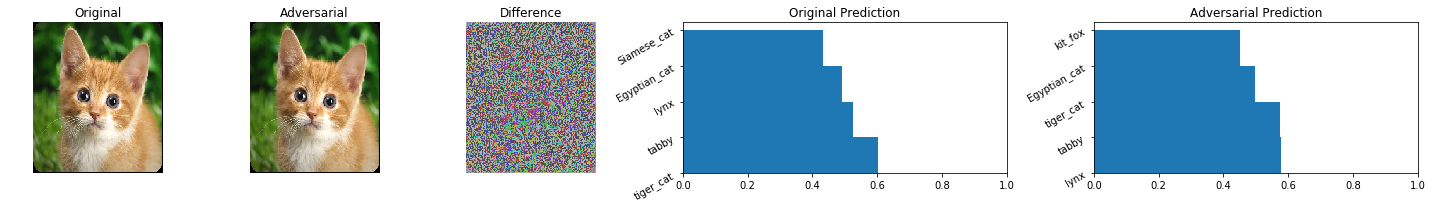

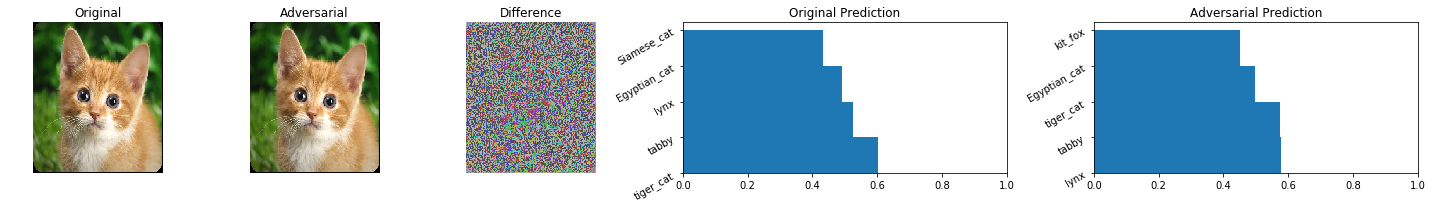

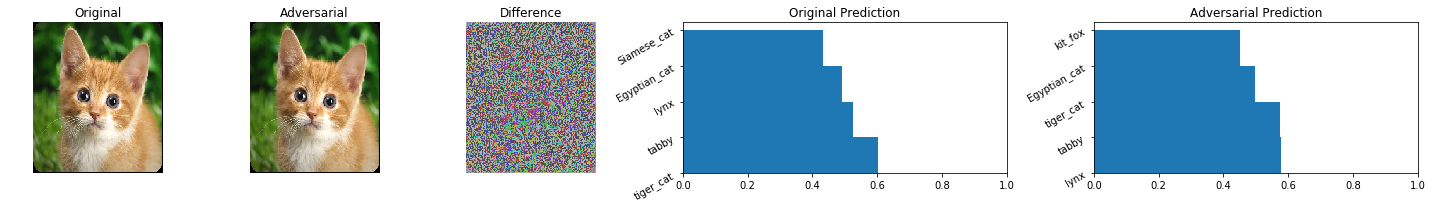

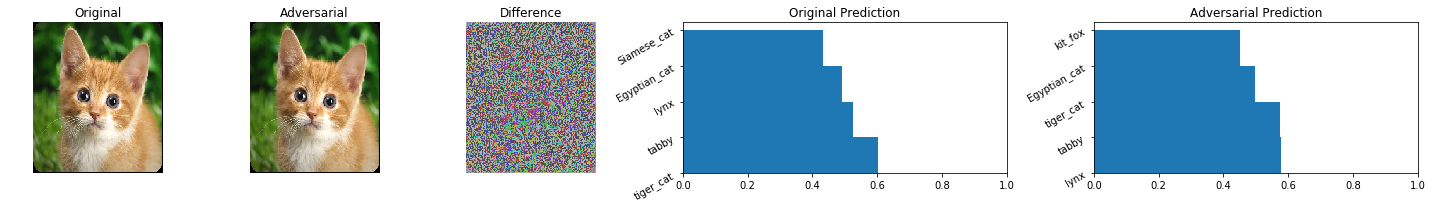

In [3]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt

from keras.preprocessing import image as image_tools
from keras.applications import imagenet_utils
from keras.applications.resnet50 import preprocess_input

def resnet50_prediction(img, keras_model):
    x = image_tools.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    classes = keras_model.predict(x)                                     
    preds = imagenet_utils.decode_predictions(classes)
    probs = [item[2] for item in preds[0]]
    names = [item[1] for item in preds[0]]
    return names, probs
    
def adversarial_plot(original_img, adversarial_img, keras_model):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
        1, 5, 
        figsize=(20, 3), 
        gridspec_kw = {
            'width_ratios':[2, 2, 2, 5, 5]
        }
    )
    
    ax1.set_title('Original')
    ax1.imshow(original_img / 255, aspect='auto')  # division by 255 to convert [0, 255] to [0, 1]
    ax1.axis('off')
    
    ax2.set_title('Adversarial')
    ax2.imshow(adversarial_img / 255, aspect='auto')  
    ax2.axis('off')
    
    ax3.set_title('Difference')
    difference = adversarial_img - original_img
    ax3.imshow(difference / abs(difference).max() * 0.2 + 0.5, aspect='auto')
    ax3.axis('off') 

    original_probs, original_names = resnet50_prediction(original_img, keras_model)
    ax4.set_title('Original Prediction')
    ax4.bar(original_names, original_probs)
    ax4.set_xlim(0., 1.)
    plt.setp(ax4.get_yticklabels(), rotation=30, horizontalalignment='right')
    
    adversarial_probs, adversarial_names = resnet50_prediction(adversarial_img, keras_model)
    ax5.set_title('Adversarial Prediction')
    ax5.bar(adversarial_names, adversarial_probs)
    ax5.set_xlim(0., 1.)
    plt.setp(ax5.get_yticklabels(), rotation=30, horizontalalignment='right')
    
    fig.tight_layout() 
    fig.show()

for i in range(0, 10):
    original_img, label = foolbox.utils.imagenet_example()
    # ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
    adversarial_img = attack(original_img[:, :, ::-1], label)
    adversarial_img = adversarial_img[:, :, ::-1] # ::-1 to convert BGR to RGB
    adversarial_plot(original_img, adversarial_img, keras_model)